**Importing Libraries and Dataset**

In [238]:
#Importing google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
#Importing pre-requisite libaries
import os
import re
import nltk
import glob
import tqdm
import pickle
import random
import string
import inflect
import operator
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import tokenize
from nltk import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from prettytable import PrettyTable
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [240]:
#Fetching stopwords
stop_words = set(stopwords.words('english'))

In [241]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [242]:
import itertools
colors = itertools.cycle(["r", "b", "g"])

**Pre-processing of data**

In [243]:
'''
Pre-processing steps:
1.Strip the data for each files 
2.Convert into lower case
3.Tokenize the data
4.Converting the number into word like 12 -> twelve
5.Remove punctuation
6.Removing single alphabet
7.Remove stop words
8.Apply lemmetization
'''
def preprocessingData(tokens):
    token = [word.lower() for word in tokens]
    currentWordsList = []
    for singleWord in token:
        if singleWord.isdigit():
            try:
                currentWords = p.number_to_words(singleWord)
                currentWordsList.append(currentWords)
            except:
                currentWordsList.append(singleWord)
        else:
            currentWordsList.append(singleWord)
    punctuationsList = str.maketrans('  ', '  ', string.punctuation)
    removedpunctuation = [w.translate(punctuationsList) for w in currentWordsList]
    removedStopwords = [word for word in removedpunctuation if word.isalpha()]
    finalTokensList = [w for w in removedStopwords if not w in stop_words]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    psObject = PorterStemmer()
    finalTokensList = [psObject.stem(word) for word in finalTokensList]
    return finalTokensList

In [244]:
#Creating paths from the datapath provided
def pathsCreation(dataPath):
    iterator = 0
    filesList = ['comp.graphics',"sci.med", "talk.politics.misc","rec.sport.hockey","sci.space"]
    folderPath = "/content/drive/MyDrive/Assignments/IR Assignment 2/Data/20_newsgroups"
    pathList = []
    LA = []
    filesPath = glob.glob(dataPath)
    for f in tqdm(filesPath,leave=True,position=0,desc ="File Processed Till now"):
        nameOfFile,tailOfFile = os.path.split(f)
        for iterator in filesList:
          if(tailOfFile == iterator):
            for file in glob.glob(f+"/*"):
                nameOfFile1,tailOfFile1 = os.path.split(file)
                pathList.append(str(folderPath)+"/"+tailOfFile+"/"+tailOfFile1)
                LA.append(tailOfFile)
    return pathList,LA

In [245]:
#Defining directory path
dirpath = "/content/drive/MyDrive/Assignments/IR Assignment 2/Data/20_newsgroups/*"

In [246]:
# Creating path and name of files list
pathGot,namesGot = pathsCreation(dirpath)

File Processed Till now: 100%|██████████| 5/5 [00:00<00:00, 36.30it/s]


**Creating Dataframe and Defining other Requisite Utility functions**

In [247]:
#Creating Dataframe
document_iterator=0
documentsList = []
print("Creating dataframe...")
for iterator in tqdm(pathGot):
  dataText = open(iterator,mode='r',errors='ignore', encoding='UTF8').read().strip()
  tokensCreated = tokenize.RegexpTokenizer(r'\w+').tokenize(dataText)
  dataTokens = preprocessingData(tokensCreated)
  documentsList.append(dataTokens)
  document_iterator += 1
df = pd.DataFrame([documentsList, namesGot]).T
print("Dataframe Created Successfully")

Creating dataframe...


100%|██████████| 5000/5000 [00:45<00:00, 110.46it/s]


Dataframe Created Successfully


In [248]:
#Displaying top 5 rows of dataframe created above
df.head()

,0,1
0,"[newsgroup, comp, graphic, path, cantaloup, sr...",comp.graphics
1,"[xref, cantaloup, srv, cs, cmu, edu, comp, gra...",comp.graphics
2,"[newsgroup, comp, graphic, path, cantaloup, sr...",comp.graphics
3,"[path, cantaloup, srv, cs, cmu, edu, crabappl,...",comp.graphics
4,"[newsgroup, comp, graphic, path, cantaloup, sr...",comp.graphics


In [249]:
#Creating file classes list
fileClassesList = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'sci.space', 'talk.politics.misc']

In [250]:
#Split of dataset on random manner depends on ratios used
def randomSplitFunction(dataFiles,ratioUsed):
    randomBooleanUsed = np.random.rand(len(dataFiles)) < ratioUsed
    trainFiles = dataFiles[randomBooleanUsed]
    testFiles = dataFiles[~randomBooleanUsed]
    return trainFiles,testFiles

In [251]:
#Creating function to reseting the index
def resetIndexFunction(trainDataFiles,testDataFiles):
    trainFinal = trainDataFiles.reset_index(drop=True)
    testFinal = testDataFiles.reset_index(drop=True)
    splittedTrainClass = Counter(trainFinal[1])
    print(color.BOLD+"Count in Classes: "+str(splittedTrainClass)+color.END)
    print()
    return trainFinal,testFinal,splittedTrainClass

In [252]:
#Creating function to count the number of words in specific class
def countWordsInClass(trainDataFiles):
    wordDictionary= {}
    for iterator in range(0,len(trainDataFiles)):
        try:
            wordDictionary[trainDataFiles[1][iterator]] = wordDictionary[trainDataFiles[1][iterator]] + trainDataFiles[0][iterator]
        except:
            wordDictionary[trainDataFiles[1][iterator]] = trainDataFiles[0][iterator]
    return wordDictionary

In [253]:
#Creating function to count the number of UNIQUE words in a specific class
def countUniqueWords(wordDictionary):
    uniqueWords = set()
    for iterator in wordDictionary:
        uniqueWords = uniqueWords | set(wordDictionary[iterator])
    uniqueWordsList = len(uniqueWords)
    return uniqueWords,uniqueWordsList

In [254]:
#class frequency for each word
def findCF(wordDictionary):
    CFValues = {}
    for iterator in wordDictionary:
        for w in set(wordDictionary[iterator]):
            CFValues[w] = []
    for iterator in wordDictionary:
        for w in set(wordDictionary[iterator]):
            if iterator == 'comp.graphics':
                CFValues[w].append(iterator)
            elif iterator == 'sci.med':
                CFValues[w].append(iterator)
            elif iterator == 'rec.sport.hockey':
                CFValues[w].append(iterator)
            elif iterator == 'sci.space':
                CFValues[w].append(iterator)        
            else:
                CFValues[w].append(iterator)
    for x,y in CFValues.items():
        CFValues[x] = len(y)
    return CFValues

In [255]:
#Creating function to evaluate class frequency
def classDFrequencyEvaluation(w,CFValues):
    rand = 0
    try:
        rand = CFValues[w]
    except:
        pass
    return rand

In [256]:
#Creating function to TF-ICF value
def tfIcfEvaluation(wordDictionary,CF):
    tfIcfValues = {}
    N=5
    for iterator in wordDictionary:
        tempDictonary={}
        count=Counter(wordDictionary[iterator])
        wordCount=len(wordDictionary[iterator])
        for word in set(wordDictionary[iterator]):
            termFrequency = count[word]/wordCount
            classFrequency = classDFrequencyEvaluation(word,CF)
            inverseClassFrequency = np.log((N)/(classFrequency))
            tempDictonary[word] = termFrequency*inverseClassFrequency
        tfIcfValues[iterator] = tempDictonary
    return tfIcfValues

In [257]:
#Creating function that will find top K-Features by using TF-ICF value
def kFeatureUsingTfIcf(TF_ICF,featureValue):
    finalFeaturesList=[]
    kFeaturesList={}
    for iterator in TF_ICF.keys():
        tempFeatures=[]
        sortedK = sorted(TF_ICF[iterator], key=TF_ICF[iterator].get, reverse=True)
        for iteratorTwo in sortedK[0:int(featureValue)]:
            finalFeaturesList.append(iteratorTwo)
            tempFeatures.append(iteratorTwo)
        kFeaturesList[iterator] = tempFeatures
    return kFeaturesList,finalFeaturesList

In [258]:
#Creating function to evaluate class frequences
def countFrequencies(classList,TF_icfFeatures,kFeatures):
    classOne = {}
    classTwo = {}
    for i in classList:
        countTopKFeatures = Counter(kFeatures[i])
        for j in TF_icfFeatures:
            classOne[i, j] = countTopKFeatures[j]
            try:
                classTwo[i] = classTwo[i] + countTopKFeatures[j]
            except:
                classTwo[i] = countTopKFeatures[j]
    return classOne,classTwo

In [259]:
def frequency(w, l,classOne,classTwo):
    try:
        return classOne[l, w],classTwo[l]
    except:
        return 0, classTwo[l]

In [260]:
#Creating function for Naive-Bayes algorithm driver code
def nbAlgoFunction(disctintWordsC,classTrainSplit,trainData,testData,allClasses,classOne,classTwo):
    truthValues = []
    predictedValues = []
    for iterator in range(testData.shape[0]):
        truthValues.append(testData[1][iterator])
        classWordProbability = []
        for l in allClasses:
            wordProbability = 0
            for w in testData[0][iterator]:
                freq, count = frequency(w, l,classOne,classTwo)
                pp = (freq + 1) / (count + disctintWordsC)
                wordProbability += np.log(pp)
            wordProbability += np.log(classTrainSplit[l] / trainData.shape[0])            
            classWordProbability.append(wordProbability)           
        predictedValues.append(allClasses[np.argmax(classWordProbability)])        
    return truthValues,predictedValues

In [261]:
#Creating function for evaluating accuracy
def aacuracyEvaluation(predValues, truthValues):
    valueOne = len([1 for i in range(len(predValues)) if predValues[i]==truthValues[i]])
    return valueOne/len(predValues)

In [262]:
#Creating function for evaluating confusion matrix
def evaluateConfusionMatrix(predValues, truthValues,classes):
    cMatrix = np.zeros((len(classes), len(classes))).astype(int)
    for i in range(len(predValues)):
        cMatrix[classes.index(predValues[i])][classes.index(truthValues[i])] += 1
    return cMatrix

In [263]:
#Creating function for evaluating heatmap
def heatmap(conf_mat):
    sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues')

**Defining Driver Code**

In [264]:
#Creating Driver function
def helperFunction(dataFiles,ratio):
    trainDataFiles,testData = randomSplitFunction(dataFiles,ratio)
    trainDataFiles,testData,train_class_split = resetIndexFunction(trainDataFiles,testData)
    wordDictionary = countWordsInClass(testData)
    distinct_words,distinct_words_c = countUniqueWords(wordDictionary)
    CFValues = findCF(wordDictionary)
    valueTFICF = tfIcfEvaluation(wordDictionary,CFValues)
    valuesFeature = [10,20,40,50,60,70]
    for fValue in valuesFeature:
        k_feature,featTFICF = kFeatureUsingTfIcf(valueTFICF,fValue)
        class_f,class_c = countFrequencies(fileClassesList,featTFICF,k_feature)
        truthValues,predictedValues = nbAlgoFunction(distinct_words_c,train_class_split,trainDataFiles,testData,fileClassesList,class_f,class_c)
        accuracyEvaluated = aacuracyEvaluation(predictedValues,truthValues)
        print(color.BOLD+"Training data size: "+str(ratio*100)+" %"+color.END)
        print(color.BOLD+"Feature Selected: "+str(fValue)+color.END)
        print(color.BLUE+color.BOLD+"Accuracy Achieved: "+str("{:.2f}".format(accuracyEvaluated*100))+" %"+color.END)
        confusionMatrixEvaluated = evaluateConfusionMatrix(predictedValues,truthValues,fileClassesList)
        print(color.BLUE+color.BOLD+"Confusion Matrix: "+color.END)
        print(confusionMatrixEvaluated)
        print()
        featureList.append(fValue)
        listPref.append(accuracyEvaluated)
        listTrainSize.append(ratio)

In [265]:
#Defining features, train dataset and ratio/proportion list
featureList = []
listPref = []
listTrainSize = []
proportionUsed = [0.5,0.7,0.8]
s=1
for currentRatio in proportionUsed:
    print(color.BOLD+"Case "+str(s)+color.END)
    helperFunction(df,currentRatio)
    print("----------------------------------")
    print("----------------------------------")
    print()
    s+=1

Case 1
Count in Classes: Counter({'rec.sport.hockey': 503, 'comp.graphics': 499, 'sci.space': 499, 'sci.med': 481, 'talk.politics.misc': 469})

Training data size: 50.0 %
Feature Selected: 10
Accuracy Achieved: 80.74 %
Confusion Matrix: 
[[481   0   7   9   4]
 [  0 497   0   0 117]
 [  0   0 261   4  44]
 [  0   0 236 487  34]
 [ 20   0  15   1 332]]

Training data size: 50.0 %
Feature Selected: 20
Accuracy Achieved: 87.17 %
Confusion Matrix: 
[[493   0   7   7   1]
 [  1 497   3   6  86]
 [  0   0 333   4  12]
 [  0   0 171 483  16]
 [  7   0   5   1 416]]

Training data size: 50.0 %
Feature Selected: 40
Accuracy Achieved: 90.23 %
Confusion Matrix: 
[[497   0   9   9  23]
 [  4 497   3   6  36]
 [  0   0 377   6  15]
 [  0   0 124 479   7]
 [  0   0   6   1 450]]

Training data size: 50.0 %
Feature Selected: 50
Accuracy Achieved: 91.96 %
Confusion Matrix: 
[[497   0   7  12   8]
 [  4 497   5   3  32]
 [  0   0 387   5   3]
 [  0   0 116 480   5]
 [  0   0   4   1 483]]

Training dat

In [266]:
#Displaying accuracies of model on different proportion/ratio of total data considered as training data
myTable = PrettyTable()
myTable.field_names = [color.BOLD+"Training Data Proportion"+color.END,color.BOLD+ "Features Selected/Class (On basis of TF-ICF) "+color.END,color.BOLD+"Accuracy Achieved"+color.END]
for i in range(len(listTrainSize)):
    myTable.add_row([color.BOLD+str(round(listTrainSize[i]*100))+" %"+color.END,color.BLUE+color.BOLD+str(round(featureList[i]))+color.END,color.DARKCYAN+color.BLUE+str("{:.2f}".format(listPref[i]*100))+" %"+color.END])
print(myTable)

+--------------------------+-----------------------------------------------+-------------------+
| Training Data Proportion | Features Selected/Class (On basis of TF-ICF)  | Accuracy Achieved |
+--------------------------+-----------------------------------------------+-------------------+
|           50 %           |                       10                      |      80.74 %      |
|           50 %           |                       20                      |      87.17 %      |
|           50 %           |                       40                      |      90.23 %      |
|           50 %           |                       50                      |      91.96 %      |
|           50 %           |                       60                      |      93.10 %      |
|           50 %           |                       70                      |      93.53 %      |
|           70 %           |                       10                      |      97.86 %      |
|           70 %           |  

**Plotting graph between Accuracy and Number of features selected from Every class**

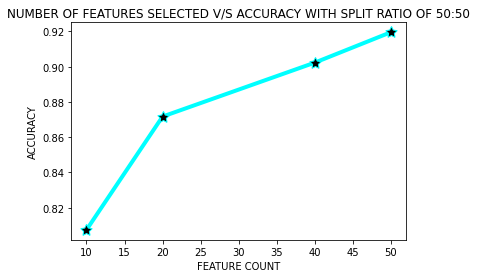

In [267]:
#On train:test ratio of 50:50
plt.plot(featureList[0:4],listPref[0:4],color='cyan',linewidth=4,
         marker=(5,1),markerfacecolor='black',markersize=12)
plt.xlabel("FEATURE COUNT")
plt.ylabel("ACCURACY")
plt.title("NUMBER OF FEATURES SELECTED V/S ACCURACY WITH SPLIT RATIO OF 50:50")
plt.show()

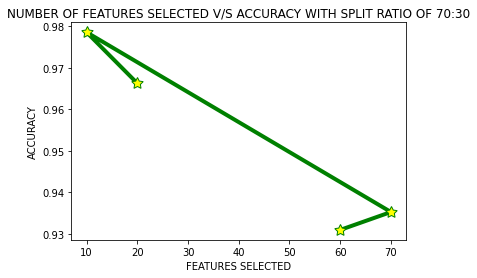

In [268]:
#On train:test ratio of 70:30
plt.plot(featureList[4:8],listPref[4:8],color='green',linewidth=4,
         marker=(5,1),markerfacecolor='yellow',markersize=12)
plt.xlabel("FEATURES SELECTED")
plt.ylabel("ACCURACY")
plt.title("NUMBER OF FEATURES SELECTED V/S ACCURACY WITH SPLIT RATIO OF 70:30")
plt.show()

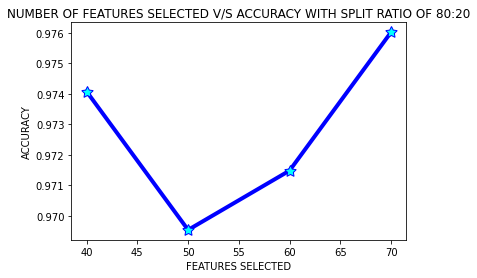

In [269]:
#On train:test ratio of 80:20
plt.plot(featureList[8:12],listPref[8:12],color='blue',linewidth=4,
         marker=(5,1),markerfacecolor='cyan',markersize=12)
plt.xlabel("FEATURES SELECTED")
plt.ylabel("ACCURACY")
plt.title("NUMBER OF FEATURES SELECTED V/S ACCURACY WITH SPLIT RATIO OF 80:20")
plt.show()

**Plotting graph to display the variation of Accuracy on different Training Data size used**

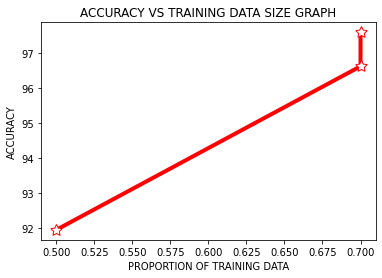

In [270]:
plt.plot([listTrainSize[3],listTrainSize[7],listTrainSize[11]],[listPref[3]*100,listPref[7]*100,listPref[11]*100],
         color='red',linewidth=4,
         marker=(5,1),markerfacecolor='white',markersize=12)
plt.xlabel("PROPORTION OF TRAINING DATA")
plt.ylabel("ACCURACY")
plt.title("ACCURACY VS TRAINING DATA SIZE GRAPH")
plt.show()